In [2]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [3]:
height , width = 1024 , 1024 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_table')
  column_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_column')

  table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  column_path = tf.strings.regex_replace(column_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  #reading  , resizing and normalizing for column mask data
  column_mask = tf.io.read_file(column_path)
  column_mask = tf.image.decode_jpeg(column_mask, channels=1) 
  column_mask = tf.image.resize(column_mask, [height, width]) 
  column_mask = tf.cast(column_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask, "column_mask" : column_mask }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data
    
#Create a source dataset from given  input data
dataset = tf.data.Dataset.list_files("C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/data/marmots_usuals/*.jpeg")

train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1) 

In [4]:
#input size for all image should be 1024 * 1024 with three channels
inputShape = (1024, 1024, 3)
inputs = Input(shape=inputShape, name='input')

#importing  pre trained VGG19 model till to bottle neck
vgg_19=tf.keras.applications.VGG19(input_tensor=inputs,include_top=False, weights='imagenet', pooling=None, classes=1000)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)


#taking 3rd and 4th maxpool layer from vgg_19 for decoders
block3_pool=vgg_19.get_layer('block3_pool').output
block4_pool=vgg_19.get_layer('block4_pool').output

#Table_decoder inherit from TableNet encoder which detect the table from given image create table mask      
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)

      return result

#column_decoder inherit from TableNet encoder which extact the table column  and create column mask   
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='column_mask')
        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]

      result = self.conv1(input)
      result = self.drop(result)
      result = self.conv2(result)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)
      return result
    
    
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
output2 = Column_Decoder(encoder_result)

model = Model(inputs=inputs,outputs=[output1, output2],name="tablenet")

In [5]:
from tensorflow.keras.utils import plot_model

In [6]:
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
output2 = Column_Decoder(encoder_result)

In [7]:
model = Model(inputs=inputs,outputs=[output1, output2],name="tablenet")

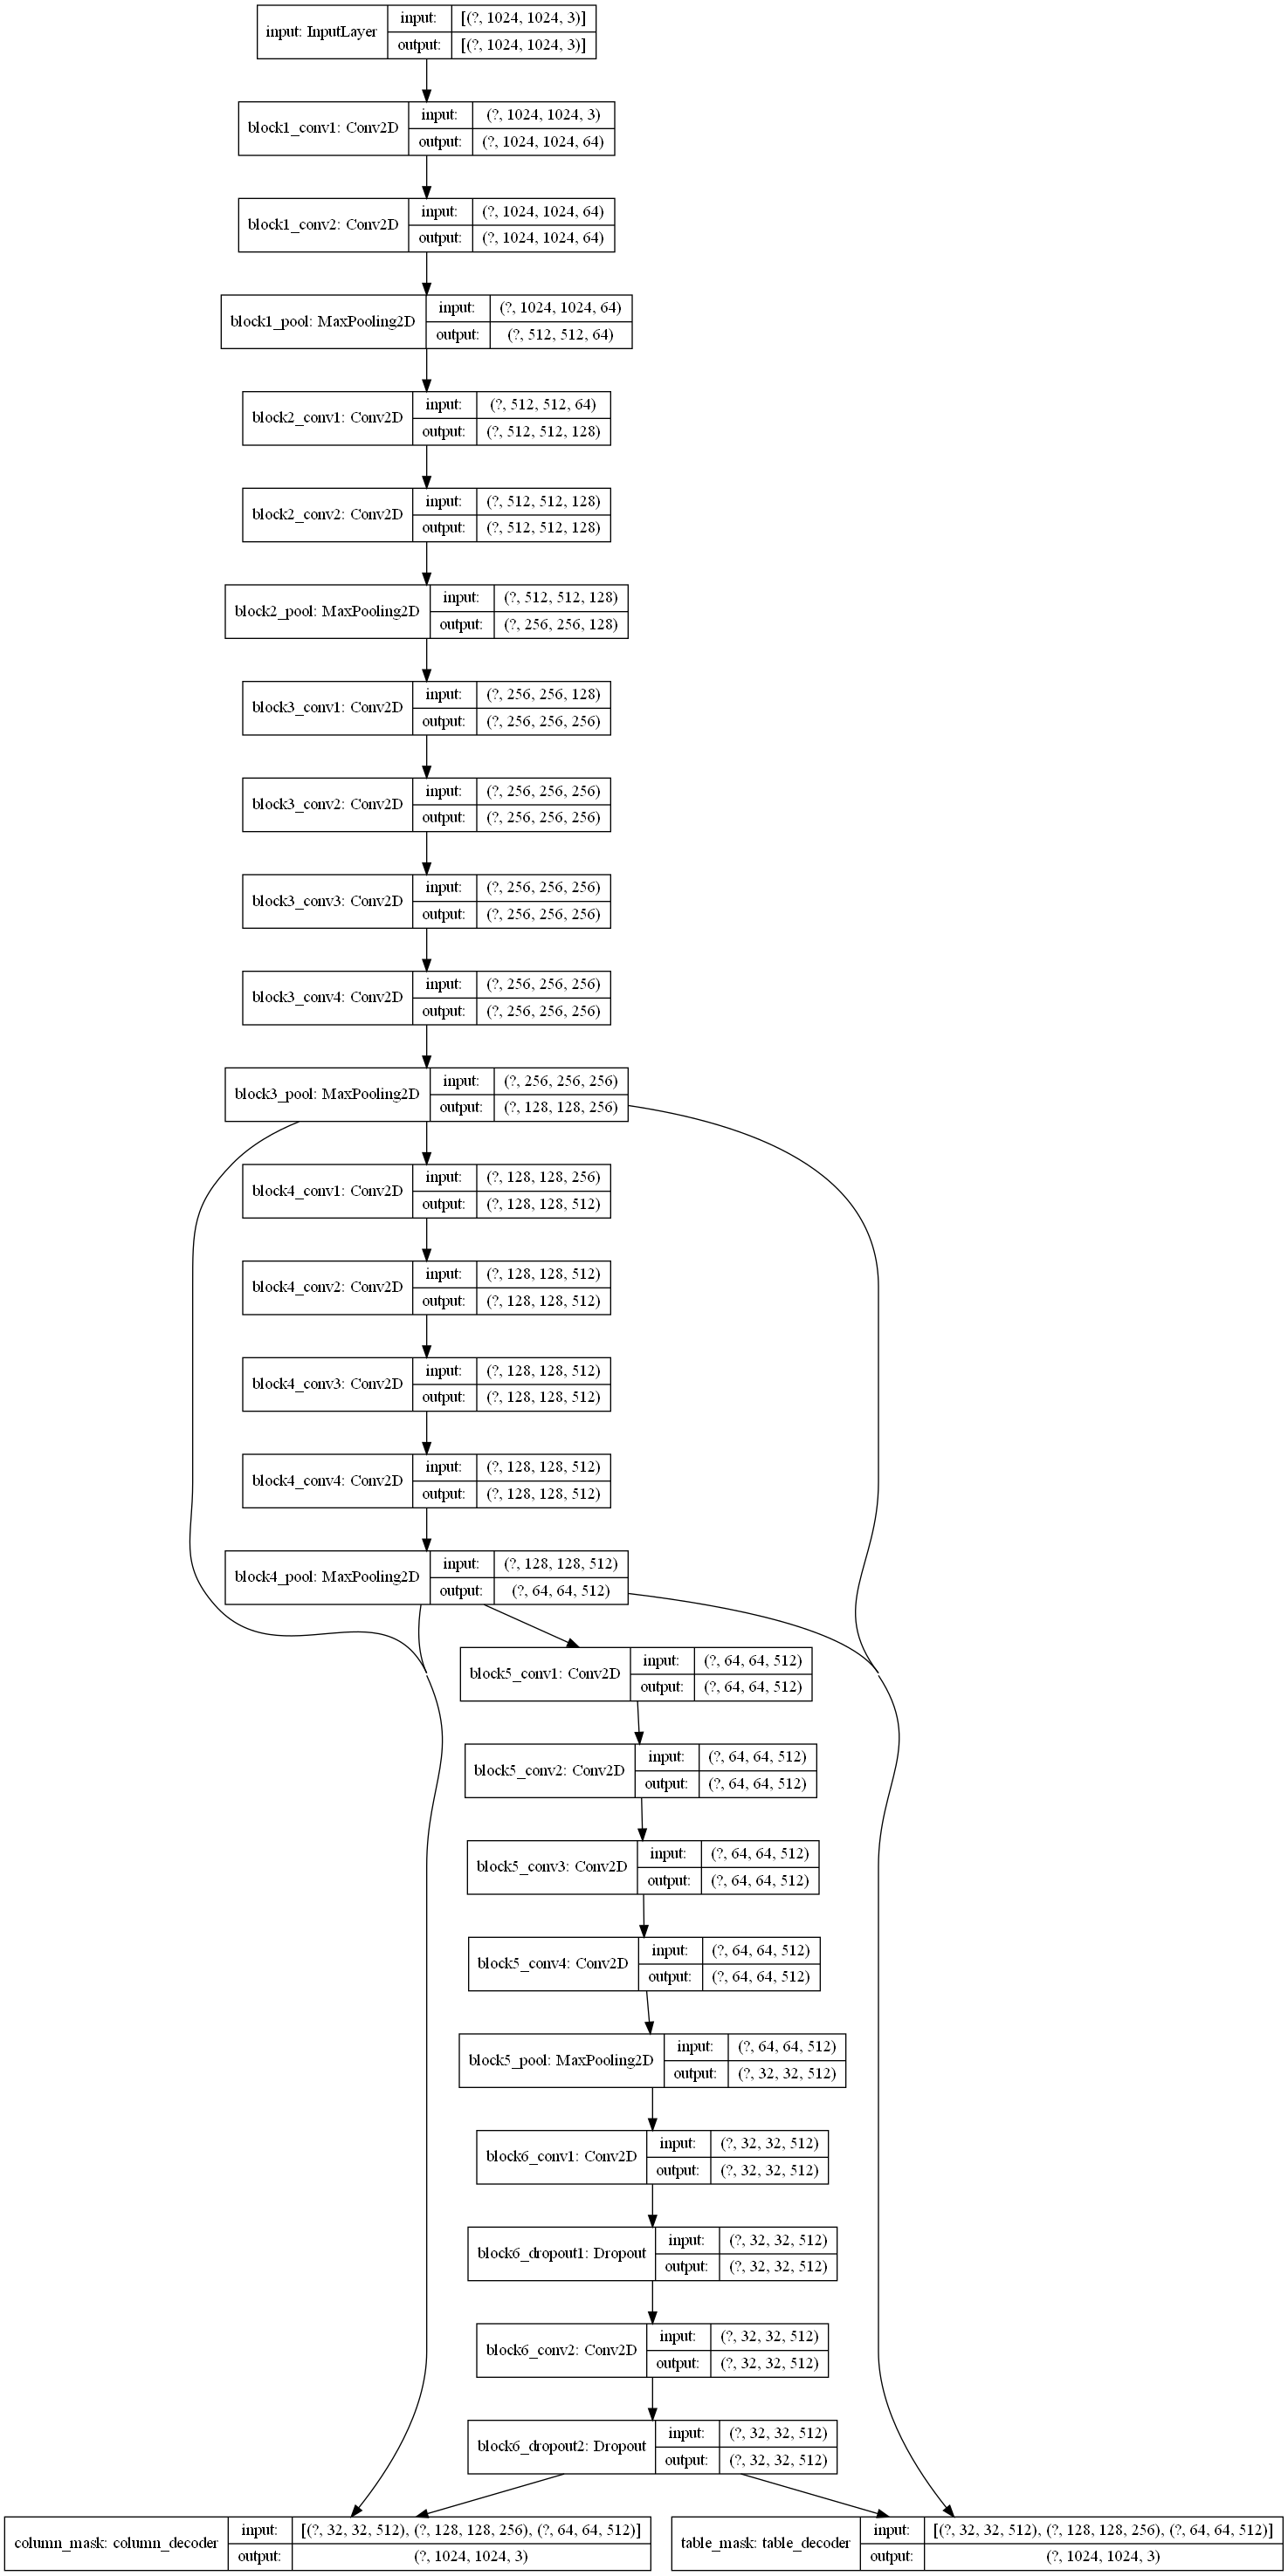

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [10]:
model.summary()

Model: "tablenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [11]:
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [12]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

In [ ]:
batch_size = 1
model_history = model.fit(train_dataloader, epochs=200,
                          steps_per_epoch=len(train_data)//batch_size,
                          validation_steps=len(test_data)//batch_size,
                          validation_data=test_dataloader, callbacks=model_checkpoint
                         )

Epoch 1/200
 12/444 [..............................] - ETA: 2:36:56 - loss: 1.8711 - table_mask_loss: 0.9544 - column_mask_loss: 0.9167 - table_mask_accuracy: 0.7742 - column_mask_accuracy: 0.8059

In [18]:
from tensorflow.keras.models import load_model
model = load_model('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/mymodel_4')

NameError: name 'model_history' is not defined

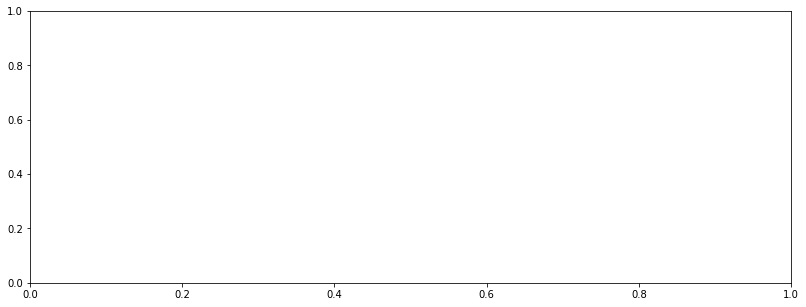

In [19]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title('Model column_mask')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
def masks(table_mask, column_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  column_mask = tf.argmax(column_mask, axis=-1)
  column_mask = column_mask[..., tf.newaxis]
  return table_mask[0], column_mask[0]

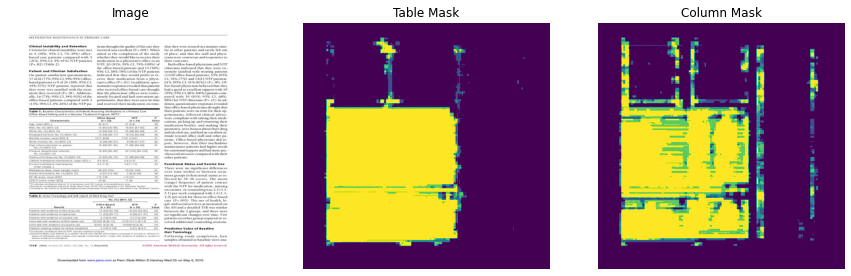

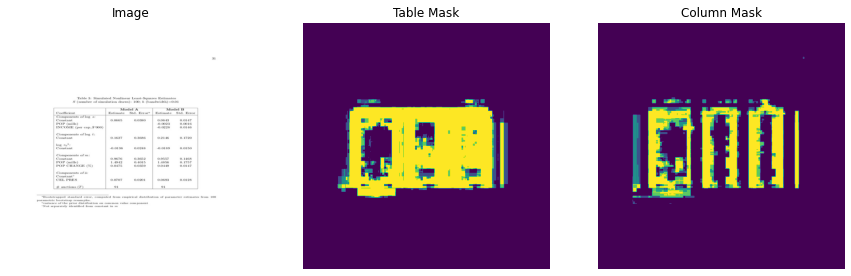

In [21]:
import numpy as np
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()

### Performance validated by Precision , Recall and F1-score :

In [22]:
import numpy as np
table , column = list() , list()
predicted_table , predicted_column = list() , list()
for image, mask  in test_data:
  table.append(mask['table_mask'])
  column.append(mask['column_mask'])
  mask1_, mask2_ = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1_, mask2_)
  predicted_table.append(table_mask)
  predicted_column.append(column_mask)

In [23]:
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics
def recall(table, predicted_table):
  m = tf.keras.metrics.Recall()
  m.update_state(table, predicted_table)
  return m.result().numpy()

def precision(table, predicted_table):
  m = tf.keras.metrics.Precision()
  m.update_state(table, predicted_table)
  return m.result().numpy()  

def result(true , pred):
  Recall = recall(true, pred)
  Precision = precision(true, pred)
  f1 = 2*(Recall * Precision)/(Recall + Precision)
  print(f'Recall is {Recall}')
  print("-"*50)
  print(f'Precision is {Precision}')
  print("-"*50)
  print(f'f1_score is {f1}')

In [24]:
#checking for table mask
result(table , predicted_table)

Recall is 0.8603010177612305
--------------------------------------------------
Precision is 0.906983494758606
--------------------------------------------------
f1_score is 0.8830256774054899


In [25]:
#checking for column mask
result(column , predicted_column)

Recall is 0.624020516872406
--------------------------------------------------
Precision is 0.76906818151474
--------------------------------------------------
f1_score is 0.6889932248423872


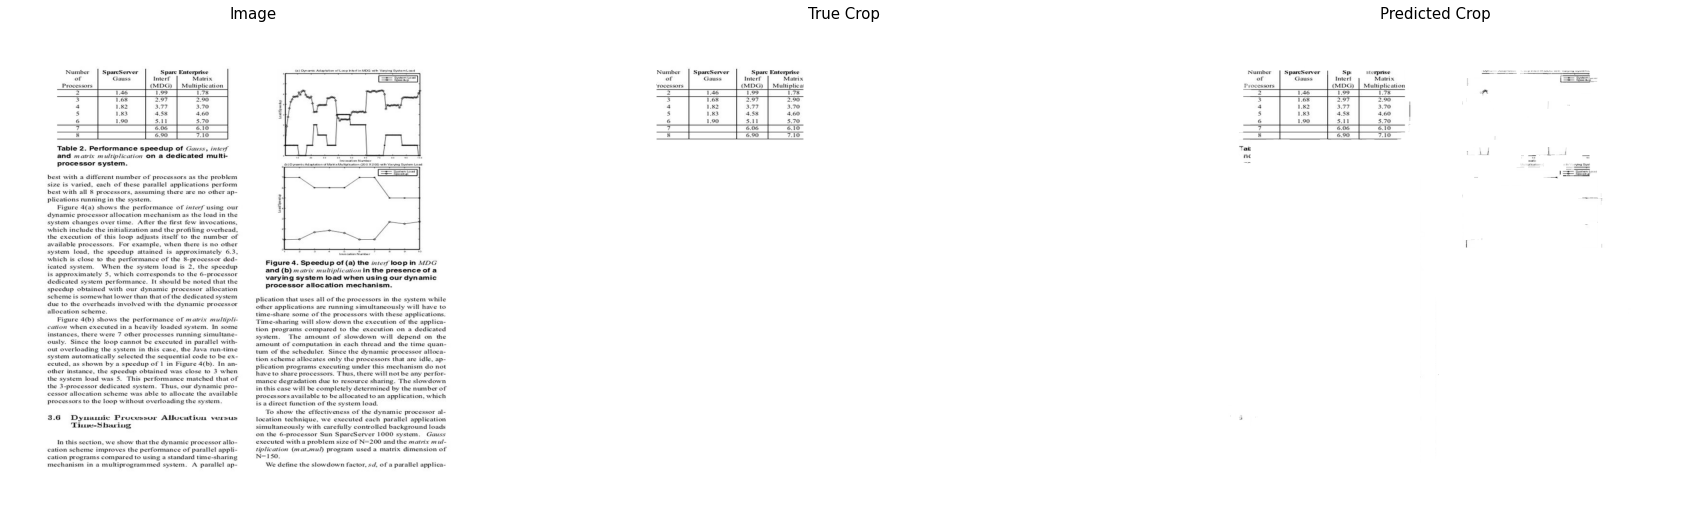

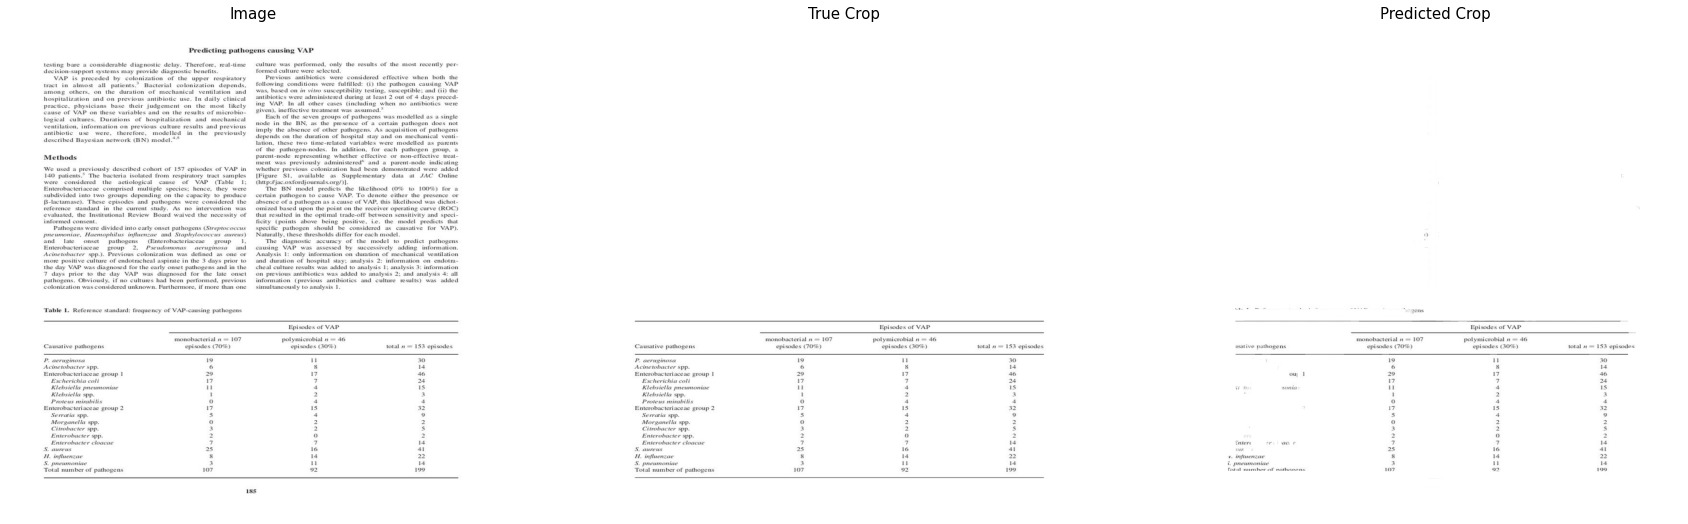

In [26]:
#randomly comparing predicted output with actual output
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(30, 50))

  true_table = mask['table_mask']
  true_table=tf.keras.preprocessing.image.array_to_img(true_table)
  true_table = true_table.convert('L')

  true_column = mask['column_mask']
  true_column=tf.keras.preprocessing.image.array_to_img(true_column)
  true_column = true_column.convert('L')


  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  pred_table = tf.keras.preprocessing.image.array_to_img(table_mask)
  pred_column = tf.keras.preprocessing.image.array_to_img(column_mask)
  pred_table = pred_table.convert('L')
  pred_column = pred_column.convert('L')


  title = ['Image', 'True Crop', 'Predicted Crop']         
  for i in range(len(title)): 
    plt.subplot(1, len(title), i+1)
    if i == 0:
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')

    elif i == 1:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(true_table)
      #img.putalpha(true_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
      plt.axis('off')

    else:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table)
      #img.putalpha(pred_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))  
      plt.axis('off')
  plt.show()

### Converting table image into text :

In [27]:
for image, mask in test_data.take(1):
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  im=tf.keras.preprocessing.image.array_to_img(image)
  im.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(table_mask)
  im.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mas/table_mask.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(column_mask)
  im.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/column_mas/column_mask.bmp')

In [28]:
#ref: https://stackoverflow.com/questions/65523727/python-image-masking-and-removing-background?noredirect=1&lq=1


# loading image , table mask and column mask from predicted model 
image  = Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp')
table_mask = Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mas/table_mask.bmp')
column_column = Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/column_mas/column_mask.bmp')

#converting table mask into grayscale
img_mask = table_mask.convert('L')    # grayscale


# add alpha channel    
image.putalpha(table_mask)

#saving image
image.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/output1.png')

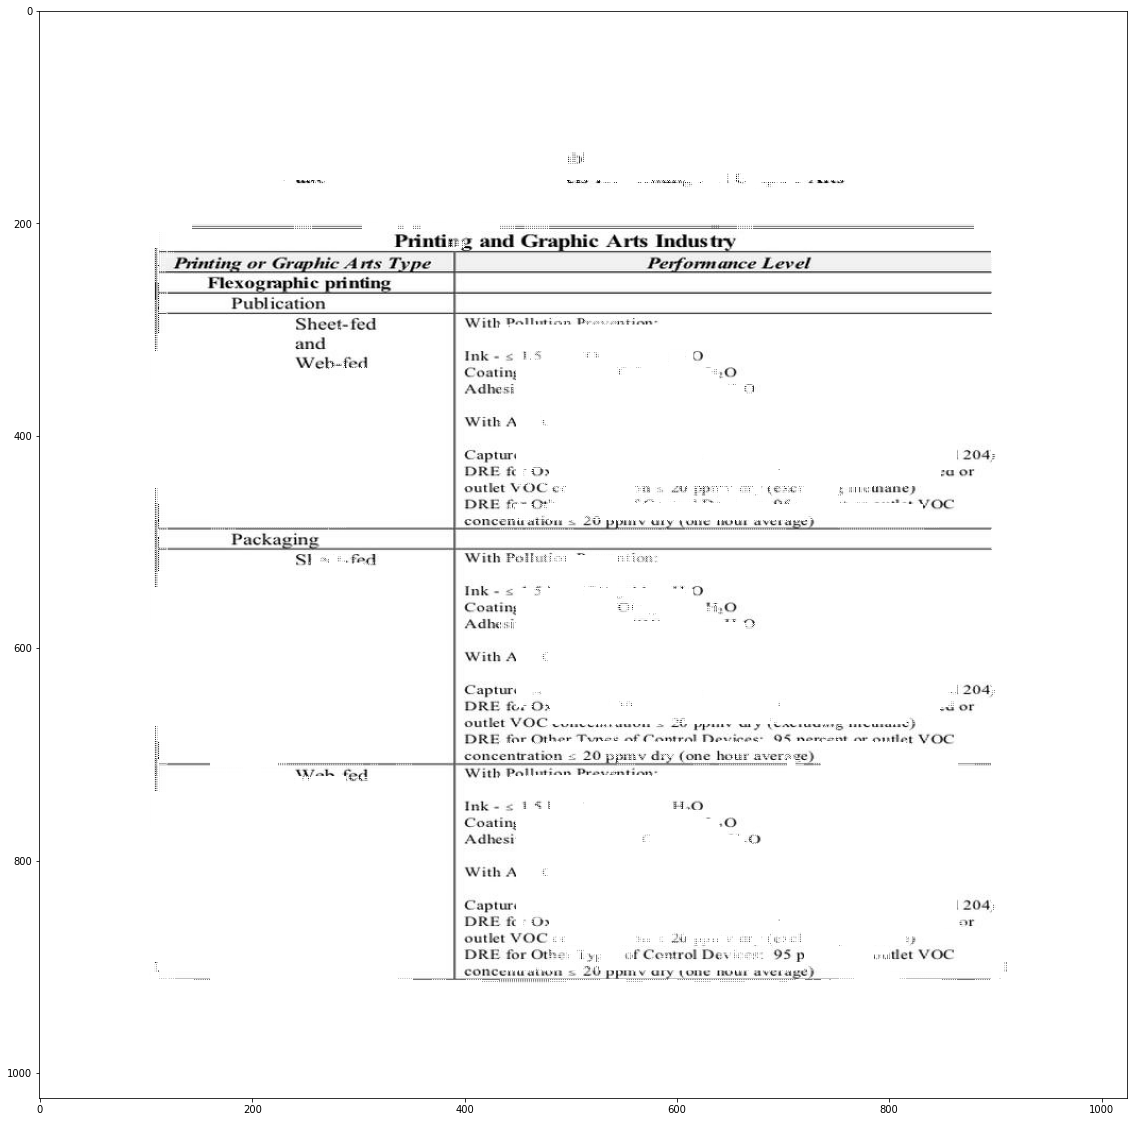

In [29]:
#showing output image 
image = cv2.imread('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/output1.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(40,20))
plt.imshow(image)

In [30]:
#installing Pillow and pytesseract
!pip install Pillow
!pip install pytesseract

In [31]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [32]:
#creating function to input image path and in return we get text file 
def ocr_tesseract(filename):
    text = pytesseract.image_to_string(Image.open(filename))  
    return text

print(ocr_tesseract('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/output1.png'))

 

 

 

Printiz.g and Graphic Arts Industry

 

"Printing or Graphic Arts Type

Performance Level

 

Flexographic printing

 

 

 

 

 

 

   

 

 

 

   

 

   

 

 

 

Publication
Sheet-fed With Patiaion Prowmtian
and awotcens
Web-fed Coating 10
Adhesi a
With A
Capturs 204;
DRE fe 0» sa or
outlet VOC «. au pp (exer mina
DRE fr- 0" o “ ne reel
a concenuation «20 pany uty ue mous average)
Cc Packaging
| ‘Sl osfed With Pollan: > Tom
Ink - = * ae
Coating 5 "0
Adhesi “oO
With A
Captur: 204;
DRE fer O» -sor
outlet VOC cee csrsunee = 2b pyres say eaceunenns
DRE for Other Tunes af Cantral Powicas: 08 nereant nr 0
: concentration < 20 ppisv dey (one hour average)
| Wa wea With Polliwinn Bravontion= _
Ink-< 135
Coatin; °
Adhesi °
With A
Capturs | 204
DRE fe“ 0» or
outlet VOC ae ‘ »
DRE for Ot iy, uf Ceatrel Devers: 95 p svutlet VOC

 

= 20 pny ary

 

We UL average)

 



### Convert table image into csv file :

In [35]:
from PIL import Image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe' 

Populating the interactive namespace from numpy and matplotlib


In [36]:
#loading the best model saved while traing for prediction
model = load_model('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/mymodel_4')

In [37]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

#creating function to input image path and in return we get text file 
def ocr_tesseract(img):
    text = pytesseract.image_to_string(img)  
    return text

def filter_word(x_min,y_min,x_max,y_max):
    #x_min,y_min,x_max,y_max = x_min,y_min,x_max,y_max
    crop = (x_min,y_min,x_max,y_max)
    cropped_table_ = img1.crop(crop)
    text = ocr_tesseract(cropped_table_)
    w = []
    for word in text.split("\n"):
        if word != '\x0c':
            w.append(str(word))

    if len(w):
        wo = ' '.join(w) 
    else:
        w.append(' ')
        wo = ' '.join(w) 
        
    return wo   


def table_csv(file_, path_):
    path = path_
    #read your file
    #file=r'exp2.png'
    file = file_
    img = cv2.imread(file,0)
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img_bin = 255-img_bin
    
    # Length(width) of kernel as 100th of total width
    kernel_len = np.array(img).shape[1]//100

    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    #Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
    
    #Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
    
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)

    x=np.ones([1024,1024])
    k= img_vh * x
    for i in range(1024):
        for j in range(1024):
            if k[i][j] != 255:
                #k[i][j][0] =  np.array([225,225,225]) 
                a = k[i][j]
                k[i][j] =  a - 255
    
    im=tf.keras.preprocessing.image.array_to_img(k[:,:,np.newaxis])
    im.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/new.bmp')
    
    fi=r'C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/new.bmp'
    imgk = cv2.imread(fi,0)

    thresh, img_vh_ = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #thresh, img_vh_ = cv2.threshold(img,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    bitxor = cv2.bitwise_xor(img,img_vh)
    bitnot = cv2.bitwise_not(bitxor)
    
    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
    
    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    #Get mean of heights
    mean = np.mean(heights)
    
    #Create list box to store all boxes in  
    box = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (w<1000 and h<500):
            image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            box.append([x,y,w,h])
            
    x = list(sorted(set([i[0] for i in box])))

    j = 0
    collect = []
    for k in x:
        if j == 0:
            j = k
        else:
            collect.append(k - j)
            j = k
        
        
    x_collect = []
    for i in range(2):
        if i == 0:
            if int(np.mean(collect)*2) <= x[i]:
                x_collect.append(x[i]-int(np.mean(collect)*2))
            else:
                x_collect.append(0)
            
        else:
            if int(np.mean(collect)*2) <= 1024-x[len(x)-1]:
                x_collect.append(x[len(x)-1]+int(np.mean(collect)*2))
            else:
                x_collect.append(1024)
    x.extend(x_collect)  

    x = sorted(x)   
    
    y = list(sorted(set([i[1] for i in box])))

    j = 0
    collect_y = []
    for k in y:
        if j == 0:
            j = k
        else:
            collect_y.append(k - j)
            j = k
        
    y_collect = []
    for i in range(2):
        if i == 0:
            if int(np.median(collect_y)*2) <= y[i]:
                y_collect.append(y[i]-int(np.median(collect_y)*2))
            else: 
                y_collect.append(0)
        else:
            if int(np.median(collect_y)*2) <= 1024-y[len(y)-1]:
                y_collect.append(y[len(y)-1]+int(np.median(collect_y)*2))
            else:
                y_collect.append(10240)

    y.extend(y_collect)   

    y = sorted(y)
    
    imk=Image.open(path)
    x_min=x[1] - 20
    y_min=y[1]
    x_max=x[len(x)-2]
    y_max=y[len(y)-2]
    crop = (x_min,y_min,x_max,y_max)
    cropped_table = imk.crop(crop)
    cropped_table.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/text.png')
    
    li = []
    img1=Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/output1.png')
    #print(file)
    #img1=Image.open(file)
    for i , m in enumerate(y):
        if i +1 != len(y):
            string = []
            for j , n in enumerate(x):
                if j +1 != len(x):
                    #print('yes')
                    x_min = n
                    y_min = m
                    x_max = x[j+1]
                    y_max = y[i+1]
                    
                    crop = (x_min,y_min,x_max,y_max)
                    cropped_table_ = img1.crop(crop)
                    text = ocr_tesseract(cropped_table_)
                    w = []
                    for word in text.split("\n"):
                        if word != '\x0c':
                            w.append(str(word))

                    if len(w):
                        wo = ' '.join(w) 
                    else:
                        w.append(' ')
                    wo = ' '.join(w)
                    #words = filter_word()
                    words = wo
                    string.append(words)
                    #print(words)
            li.append(string) 

    # name of csv file 
    filename = "C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/records.csv"
    
    # writing to csv file 
    with open(filename, 'w') as csvfile:
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerows(li)
        
    data = pd.read_csv('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/records.csv',encoding= 'unicode_escape')  
    
    #text('text.png')
    
    return data 

    

In [38]:
import cv2
import pytesseract
from pytesseract import Output
import pandas as pd

def text(path):
    #img = cv2.imread("tabular_data_1_the_perfect_format.png")
    path_ = path
    img = cv2.imread(path_)
    img = cv2.resize(img, (int(img.shape[1] + (img.shape[1] * .1)),
                       int(img.shape[0] + (img.shape[0] * .25))),
                 interpolation=cv2.INTER_AREA)

    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


    custom_config = r'-l eng --oem 3 --psm 6 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-:.$%./@& *"'
    #custom_config='--psm 10'
    d = pytesseract.image_to_data(img_rgb, config=custom_config, output_type=Output.DICT)
    df = pd.DataFrame(d)

    # clean up blanks
    df1 = df[(df.conf != '-1') & (df.text != ' ') & (df.text != '')]
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # sort blocks vertically
    sorted_blocks = df1.groupby('block_num').first().sort_values('top').index.tolist()
    for block in sorted_blocks:
        curr = df1[df1['block_num'] == block]
        sel = curr[curr.text.str.len() > 3]
        # sel = curr
        char_w = (sel.width / sel.text.str.len()).mean()
        prev_par, prev_line, prev_left = 0, 0, 0
        text = ''
        for ix, ln in curr.iterrows():
            # add new line when necessary
            if prev_par != ln['par_num']:
                text += '\n'
                prev_par = ln['par_num']
                prev_line = ln['line_num']
                prev_left = 0
            elif prev_line != ln['line_num']:
                text += '\n'
                prev_line = ln['line_num']
                prev_left = 0

            added = 0  # num of spaces that should be added
            if ln['left'] / char_w > prev_left + 1:
                added = int((ln['left']) / char_w) - prev_left
                text += ' ' * added
            text += ln['text'] + ' '
            prev_left += len(ln['text']) + added + 1
        text += '\n'
        print(text)

In [70]:
#function which predict table sub image from image and convert them into dataframe
def prediction(filepath):
    path = filepath
    #reading  , resizing and normalizing for image data
    images = tf.io.read_file(path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, [1024, 1024])  #Decode a JPEG-encoded image to a uint8 tensor
    images = tf.cast(images, tf.float32) / 255.0 # normalizing image
    
    mask1, mask2 = model.predict(images[np.newaxis,:,:,:])
    table_mask, column_mask = masks(mask1, mask2)

    im1=tf.keras.preprocessing.image.array_to_img(images)
    im1.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp')
        
    im2=tf.keras.preprocessing.image.array_to_img(table_mask)
    im2.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mask.bmp')
        
    im3=tf.keras.preprocessing.image.array_to_img(column_mask)
    im3.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/column_mask.bmp')
    
    im4  = Image.open(path)
    im4=im4.resize((1024,1024),Image.ANTIALIAS)
    im4.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp')

    im5 = Image.open('C:/Users/Soumadeep Das/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mas/table_mask.bmp')
    im5=im5.resize((1024,1024),Image.ANTIALIAS)
    im5.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mask.bmp')
    
    img_  = Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp')
    img_mask = Image.open('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mask.bmp')

    img_ = img_mask.convert('L')    # grayscale
    img_.putalpha(img_mask)
    img_.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/output.png')
    
    img = cv2.imread('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/image.bmp',cv2.IMREAD_UNCHANGED)
    img_table = cv2.imread('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/table_mask.bmp',cv2.IMREAD_UNCHANGED)

    x=np.ones([1024,1024 , 3])
    k= img * x
    for i in range(1024):
        for j in range(1024):
            if img_table[i][j] == 0:
                k[i][j] =  np.array([0,0,0])

    for i in range(1024):
        for j in range(1024):
            if k[i][j][0] == 0:
                k[i][j][0] =  255   

    for i in range(1024):
        for j in range(1024):
            if k[i][j][0] != 255:
                a = k[i][j][0]
                k[i][j][0] =  a - 255
                
    im=tf.keras.preprocessing.image.array_to_img(k)
    im.save('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/test.png') 
    
    data = table_csv(test,'C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/')
    data.to_csv('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/Table_extraction-main/Table_extraction-main/file.csv')
    return data

### Showing result with examples :

### Example 1 :

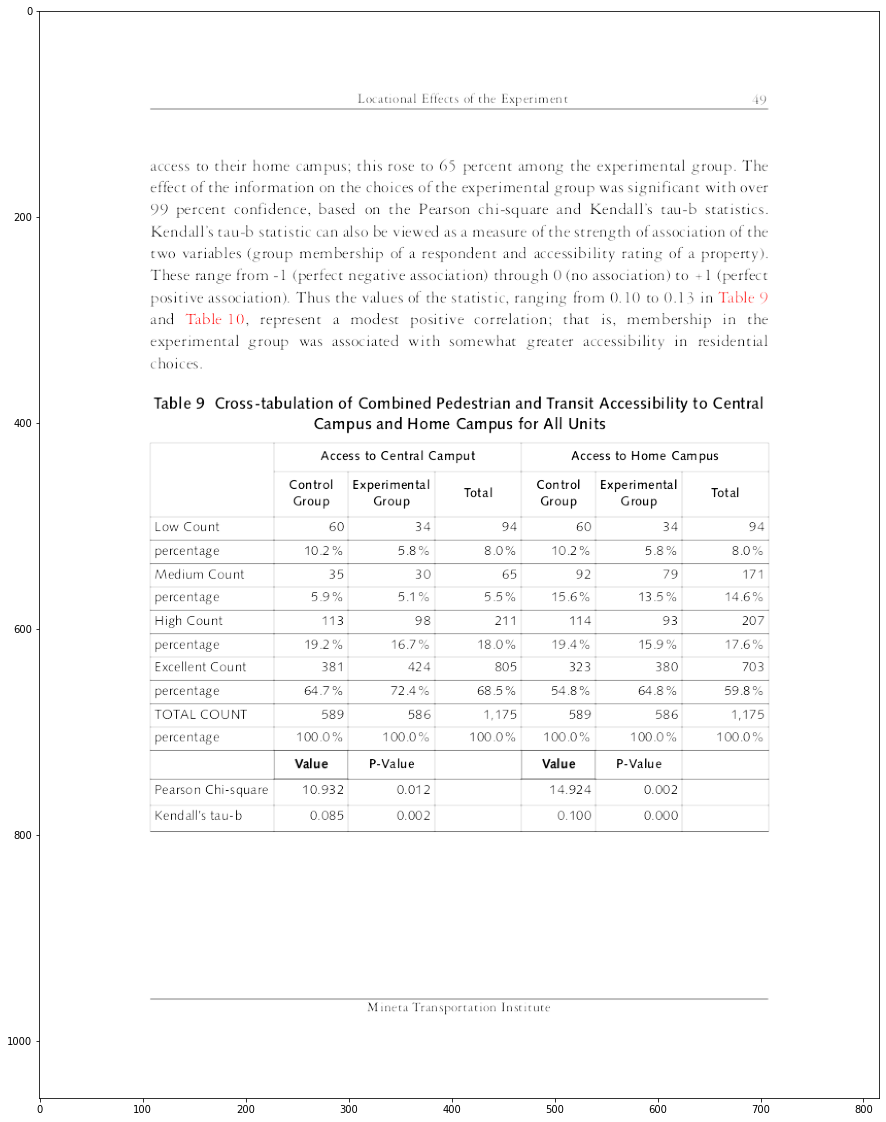

In [40]:
#showing original image
image = cv2.imread('C:/Users/zeeshan/Desktop/DATA SCIENCE/JKT/data/Marmot_data/image/10.1.1.192.1805_60.bmp',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(40,20))
plt.imshow(image)